In [1]:
import pyxdf
import mne
from mne.decoding import CSP
from mne.preprocessing import EOGRegression
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split

from mnetools import streams2mnedata, preprocessing

In [2]:
# -- |Data details| --
participant_id = 0
session = 3
# -- |Data Selection| --
initial_run = 1
n_run = 5

# -- |Parameters| --
tmin= -0.5
tmax= 3

# -- |Event dictionary| --
# Set up your event name
if session == 1 : events_id = {'right': 0, 'left': 1}
else            : events_id = {'none': 0, 'right': 1, 'left': 2}

# **Raw Data Overview**

In [3]:
# -- |Local parameters|--
epochs_list = [] 

for i in range(initial_run,initial_run+n_run):
    # -- |File import| --
    streams, header = pyxdf.load_xdf(f"Data/sub-P{participant_id:003d}/ses-S{session:003d}/eeg/sub-P{participant_id:003d}_ses-S{session:003d}_task-Default_run-{i:003d}_eeg.xdf") #Example Data from Lab Recoder

    raw_mne, events = streams2mnedata(streams)
    epochs = mne.Epochs(raw_mne, events, tmin= -0.5,  tmax= 3, event_id = events_id, preload = True,verbose=False,picks = ['C3','Cz','C4','PO7','Pz','PO8','EOG'])

    epochs_list.append(epochs)

epochs = mne.concatenate_epochs(epochs_list)
epochs.set_montage(mne.channels.make_standard_montage('standard_1020'))

Not setting metadata
230 matching events found
Applying baseline correction (mode: mean)


Number of events,230
Events,left: 75none: 80right: 75
Time range,-0.500 – 3.000 s
Baseline,-0.500 – 0.000 s


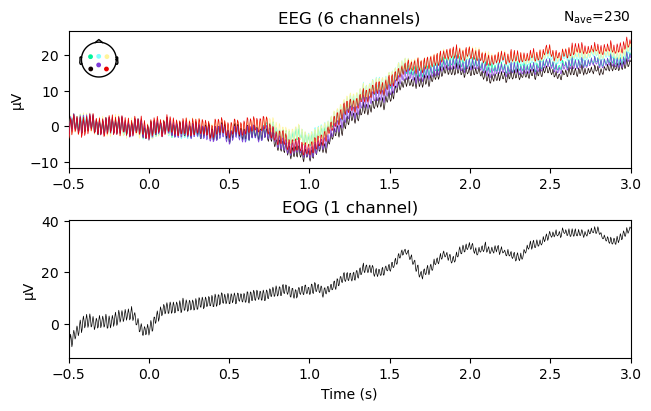

In [4]:
plot_kwargs = dict(picks="all")

# plot the evoked for the EEG and the EOG sensors
fig = epochs.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_50620\3855270505.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.compute_psd(fmin=0,fmax=50).plot()
c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


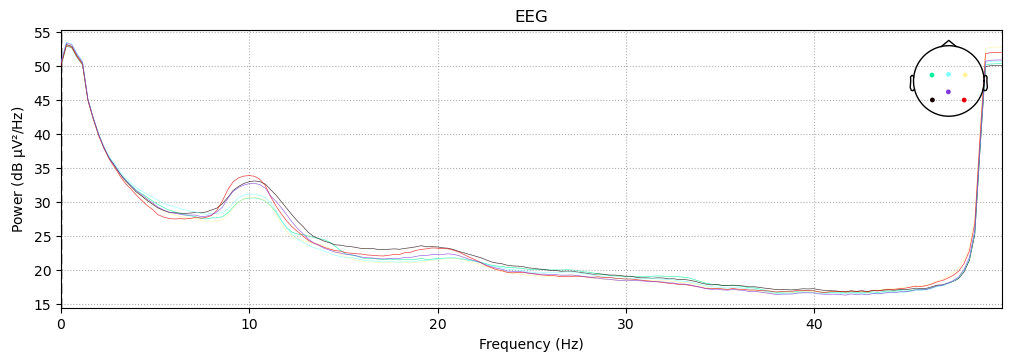

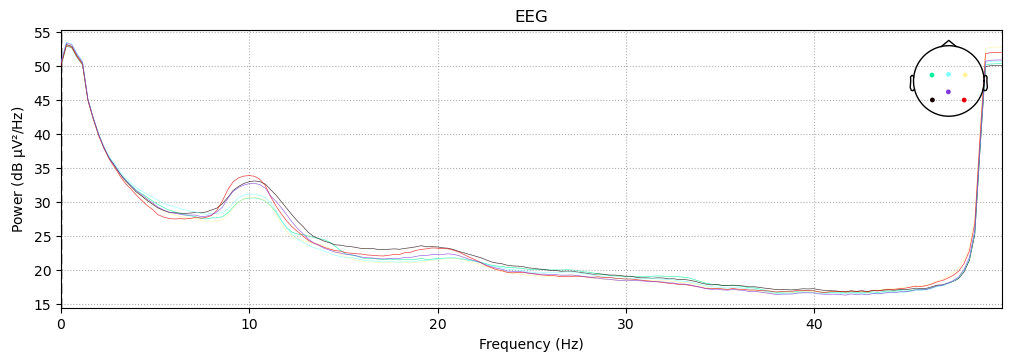

In [5]:
epochs.compute_psd(fmin=0,fmax=50).plot()

# **Processing**

In [6]:
# -- |Local parameters|--
epochs_list = [] 

for i in range(initial_run,initial_run+n_run):
    # -- |File import| --
    streams, header = pyxdf.load_xdf(f"Data/sub-P{participant_id:003d}/ses-S{session:003d}/eeg/sub-P{participant_id:003d}_ses-S{session:003d}_task-Default_run-{i:003d}_eeg.xdf") #Example Data from Lab Recoder

    raw_mne, events = streams2mnedata(streams)
    prepro_mne = preprocessing(raw_mne)
    
    # -- |Epoch Segmentation| --
    epochs = mne.Epochs(prepro_mne, events, tmin= tmin,  tmax= tmax, event_id = events_id, preload = True,verbose=False,picks = ['C3','Cz','C4','PO7','Pz','PO8','EOG'])

    epochs_list.append(epochs)

epochs = mne.concatenate_epochs(epochs_list)
epochs.set_montage(mne.channels.make_standard_montage('standard_1020'))

Not setting metadata
230 matching events found
Applying baseline correction (mode: mean)


Number of events,230
Events,left: 75none: 80right: 75
Time range,-0.500 – 3.000 s
Baseline,-0.500 – 0.000 s


## Part 1: Without artifact removal

### 1.1 Left vs. Right Classification

#### 1.1.1 SVM

Train set shape: (120, 7)
Test set shape : (30, 7)


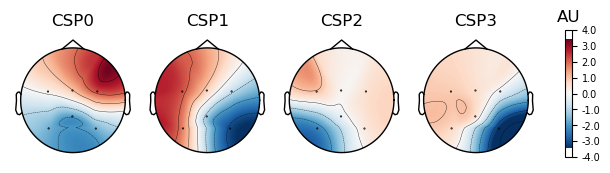

Accuracy: 0.8666666666666667
              precision    recall  f1-score   support

       right       0.82      0.93      0.87        15
        left       0.92      0.80      0.86        15

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.87      0.87      0.87        30



In [7]:
mne.set_log_level(verbose=False)

# Get EEG data and events
X = epochs[['right','left']].get_data(copy=False)
Y = epochs[['right','left']].events[:, -1]

csp_list = []
svm_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['right', 'left'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 1.1.2 Logistic Regression

Train set shape: (120, 7)
Test set shape : (30, 7)


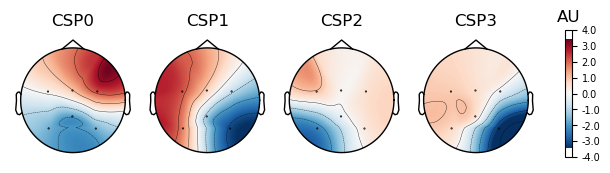

Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

  none-right       0.81      0.87      0.84        15
       right       0.86      0.80      0.83        15

    accuracy                           0.83        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.83      0.83      0.83        30



In [8]:
csp_list = []
lr_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
lr = lr_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

In [27]:
timewindow = np.full((7,500),1e-15)
channels = ['C3','Cz','C4','Pz','PO7','PO8','EOG'] # Set your target EEG channel name
info = mne.create_info(
    ch_names= channels,
    ch_types= ['eeg']*(len(channels) - 1) + ['eog'],
    sfreq= 250,  # OpenBCI Frequency acquistion
    verbose=False
)

In [85]:
sample = [np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand()]
timewindow = np.concatenate([timewindow[:,1:], (np.array([sample[1:]])/1000000).T], axis=1)
timewindow_mne = mne.io.RawArray(timewindow, info, verbose=False)
timewindow_mne = preprocessing(timewindow_mne)

realtime_data = timewindow_mne.get_data()[:,-int((tmax-tmin)*250):]
realtime_data = realtime_data - np.array([np.mean(realtime_data[:int((0-tmin)*250)], axis = 1)]).T
realtime_data

array([[-1.22132325e-09, -1.22132325e-09, -1.22132325e-09, ...,
         4.95888392e-08,  2.47485886e-08, -1.22132325e-09],
       [ 1.66767481e-09,  1.66767481e-09,  1.66767481e-09, ...,
        -1.11935297e-07, -5.74026910e-08,  1.66767481e-09],
       [ 2.20900588e-09,  2.20900588e-09,  2.20900588e-09, ...,
        -1.40046659e-07, -7.16796189e-08,  2.20900588e-09],
       ...,
       [-8.98578015e-10, -8.98578015e-10, -8.98578015e-10, ...,
         1.01376529e-07,  5.30389738e-08, -8.98578015e-10],
       [-2.15755644e-10, -2.15755644e-10, -2.15755644e-10, ...,
        -4.20932122e-09, -2.71089724e-09, -2.15755644e-10],
       [-1.06833085e-09, -1.06833085e-09, -1.06833085e-09, ...,
         7.49087027e-08,  3.84100560e-08, -1.06833085e-09]])

In [50]:
a = np.random.rand(5,6)
print(a,np.mean(a, axis = 1),a - np.array([np.mean(a, axis = 1)]).T)

[[0.77239579 0.82344556 0.10109799 0.97665597 0.85370218 0.5145009 ]
 [0.88020609 0.52985814 0.30922849 0.80889703 0.67100981 0.89380282]
 [0.40657729 0.80673603 0.3369961  0.06352312 0.34534936 0.48932078]
 [0.13263859 0.56027026 0.54247263 0.83320436 0.4185148  0.50301145]
 [0.82580282 0.23033445 0.19486639 0.46047123 0.77488679 0.01982216]] [0.67363306 0.68216706 0.40808378 0.49835202 0.41769731] [[ 0.09876273  0.14981249 -0.57253508  0.30302291  0.18006912 -0.15913217]
 [ 0.19803902 -0.15230892 -0.37293857  0.12672996 -0.01115725  0.21163576]
 [-0.00150649  0.39865225 -0.07108768 -0.34456066 -0.06273442  0.081237  ]
 [-0.36571342  0.06191824  0.04412062  0.33485234 -0.07983722  0.00465944]
 [ 0.40810551 -0.18736285 -0.22283091  0.04277392  0.35718948 -0.39787514]]


### 1.2 Left vs. Non-left Classification

#### 1.2.1 SVM

c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\Li

Train set shape: (184, 7)
Test set shape : (46, 7)


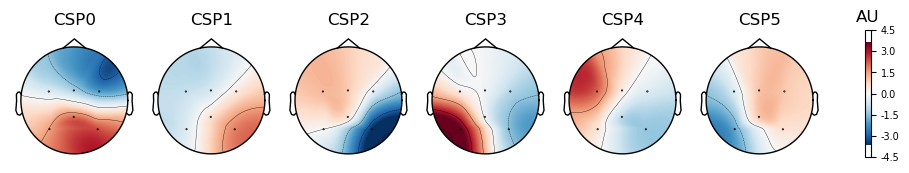

Accuracy: 0.782608695652174
              precision    recall  f1-score   support

   none-left       0.78      0.94      0.85        31
        left       0.78      0.47      0.58        15

    accuracy                           0.78        46
   macro avg       0.78      0.70      0.72        46
weighted avg       0.78      0.78      0.77        46



In [9]:
epochs_l = epochs.copy()
epochs_l.events = mne.merge_events(epochs_l.events, [0, 1], 0, replace_events=True)
epochs_l.event_id = {'none-left': 0, 'left': 2}

# Get EEG data and events
X = epochs_l.get_data(copy=False)
Y = epochs_l.events[:, -1]

csp_list = []
svm_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-left', 'left'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 1.2.2 Logistic Regression

Train set shape: (184, 7)
Test set shape : (46, 7)


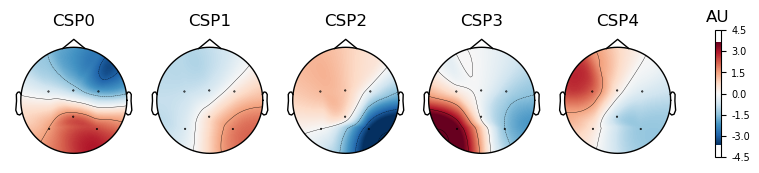

Accuracy: 0.782608695652174
              precision    recall  f1-score   support

  none-right       0.82      0.87      0.84        31
       right       0.69      0.60      0.64        15

    accuracy                           0.78        46
   macro avg       0.76      0.74      0.74        46
weighted avg       0.78      0.78      0.78        46



In [10]:
csp_list = []
lr_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
lr = lr_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

### 1.3 Right vs. Non-Right Classification

#### 1.3.1 SVM

Train set shape: (184, 7)
Test set shape : (46, 7)


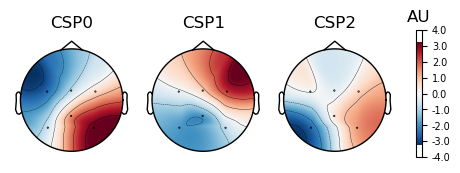

Accuracy: 0.7391304347826086
              precision    recall  f1-score   support

  none-right       0.77      0.87      0.82        31
       right       0.64      0.47      0.54        15

    accuracy                           0.74        46
   macro avg       0.70      0.67      0.68        46
weighted avg       0.73      0.74      0.73        46



In [11]:
epochs_r = epochs.copy()
epochs_r.events = mne.merge_events(epochs_r.events, [0, 2], 0, replace_events=True)
epochs_r.event_id = {'none-right': 0, 'right': 1}

# Get EEG data and events
X = epochs_r.get_data(copy=False)
Y = epochs_r.events[:, -1]

csp_list = []
svm_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 1.3.2 Logistic Regression

Train set shape: (184, 7)
Test set shape : (46, 7)


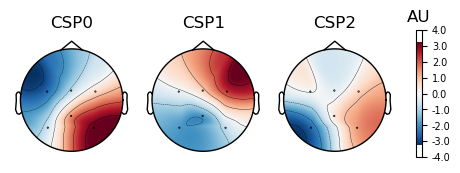

Accuracy: 0.7391304347826086
              precision    recall  f1-score   support

  none-right       0.77      0.87      0.82        31
       right       0.64      0.47      0.54        15

    accuracy                           0.74        46
   macro avg       0.70      0.67      0.68        46
weighted avg       0.73      0.74      0.73        46



In [12]:
csp_list = []
lr_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
lr = lr_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

## Part 2: With artifact removal

### Artifact Correlations

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_50620\2921723998.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+alpha)
C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_50620\2921723998.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+alpha)


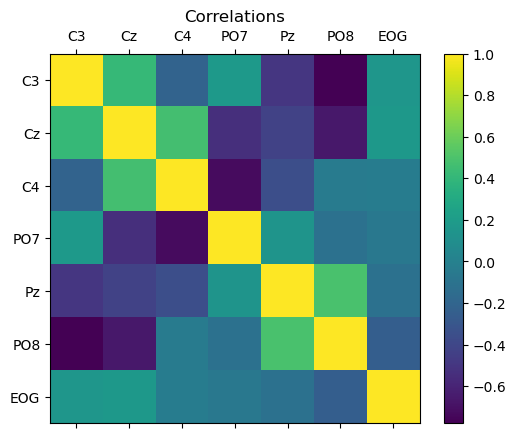

,C3,Cz,C4,PO7,Pz,PO8,EOG
C3,1.000000,0.414983,-0.210766,0.185635,-0.499314,-0.777343,0.156532
Cz,0.414983,1.000000,0.466505,-0.536934,-0.427932,-0.661764,0.169718
C4,-0.210766,0.466505,1.000000,-0.727671,-0.351492,-0.036490,-0.029611
PO7,0.185635,-0.536934,-0.727671,1.000000,0.141224,-0.116372,-0.063609
Pz,-0.499314,-0.427932,-0.351492,0.141224,1.000000,0.487658,-0.114246
PO8,-0.777343,-0.661764,-0.036490,-0.116372,0.487658,1.000000,-0.243595
EOG,0.156532,0.169718,-0.029611,-0.063609,-0.114246,-0.243595,1.000000


In [13]:
df = epochs.to_data_frame()
df_numerical = df[epochs.ch_names]

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df_numerical.corr(), interpolation='nearest')
fig.colorbar(cax)

alpha = epochs.ch_names
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
ax.set_title('Correlations')

plt.show()
df_numerical.corr()

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_50620\3594465532.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+alpha)
C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_50620\3594465532.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+alpha)


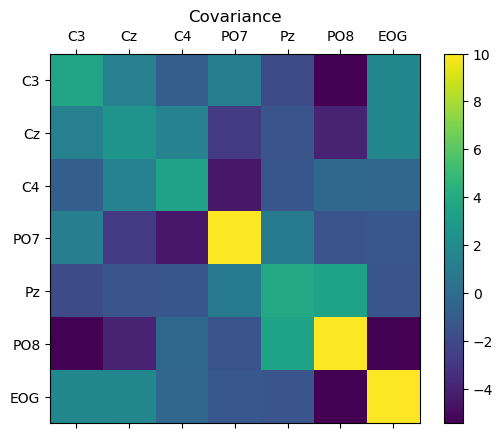

,C3,Cz,C4,PO7,Pz,PO8,EOG
C3,3.604755,1.261676,-0.747689,1.151377,-1.861726,-5.428332,1.788677
Cz,1.261676,2.564243,1.395786,-2.808800,-1.345732,-3.897611,1.635685
C4,-0.747689,1.395786,3.491135,-4.441595,-1.289741,-0.250765,-0.332984
PO7,1.151377,-2.808800,-4.441595,10.671882,0.906009,-1.398246,-1.250626
Pz,-1.861726,-1.345732,-1.289741,0.906009,3.856629,3.522371,-1.350316
PO8,-5.428332,-3.897611,-0.250765,-1.398246,3.522371,13.527938,-5.392313
EOG,1.788677,1.635685,-0.332984,-1.250626,-1.350316,-5.392313,36.222907


In [14]:
df = epochs.to_data_frame()
df_numerical = df[epochs.ch_names]

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df_numerical.cov(), interpolation='nearest',vmax=10)
fig.colorbar(cax)

alpha = epochs.ch_names
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
ax.set_title('Covariance')

plt.show()
df_numerical.cov()

In [15]:
df_numerical.corr()['EOG'][:-1].mul(df_numerical.std().iloc[:-1]/df_numerical.std().iloc[-1])

C3     0.049380
Cz     0.045156
C4    -0.009193
PO7   -0.034526
Pz    -0.037278
PO8   -0.148865
dtype: float64

### 2.1 Visualize Original Data

#### Signal Average Over Epochs

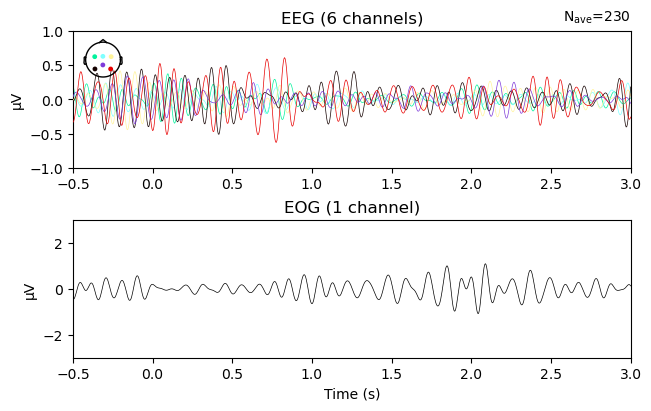

In [16]:
plot_kwargs = dict(picks="all", ylim=dict(eeg=(-1, 1), eog=(-3, 3)))

# plot the evoked for the EEG and the EOG sensors
fig = epochs.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

#### Time Domain Plot

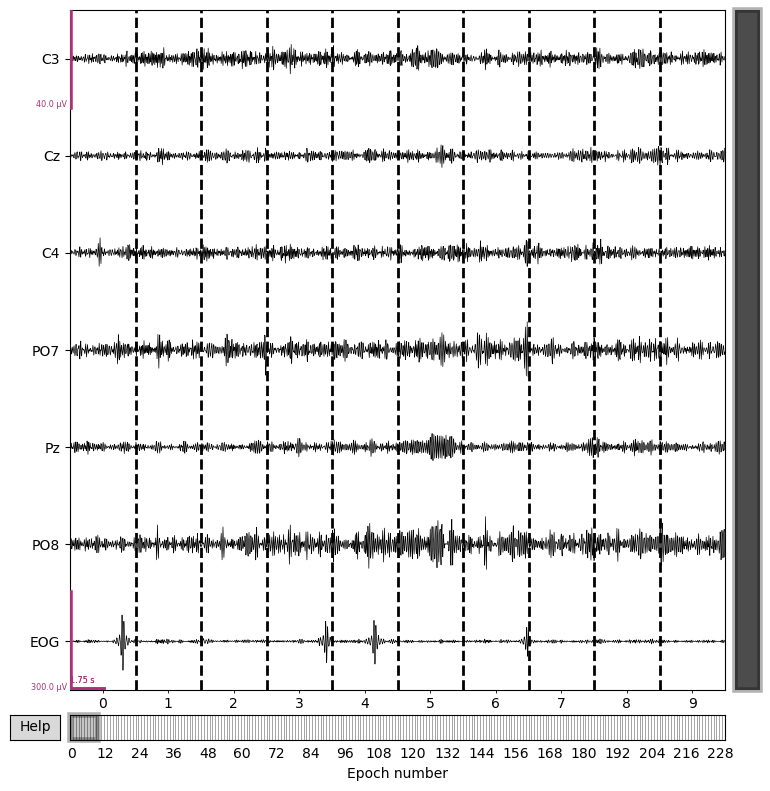

In [17]:
epochs.plot(picks='all', n_epochs=10);

### 2.2 Compute and Apply EOG Regression

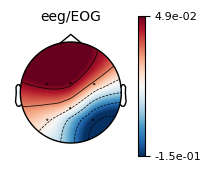

In [18]:
# Perform regression using the EOG sensor as independent variable and the EEG
# sensors as dependent variables.
model_plain = EOGRegression(picks="eeg", picks_artifact="eog").fit(epochs)

epochs_clean_plain = model_plain.apply(epochs)
# After regression, we should redo the baseline correction
epochs_clean_plain.apply_baseline()

fig = model_plain.plot()  # regression coefficients as topomap
fig.set_size_inches(3, 2)

In [86]:
model_plain.coef_

array([[ 0.0493872 ],
       [ 0.04515629],
       [-0.00918784],
       [-0.03450529],
       [-0.03728514],
       [-0.1488773 ]])

#### Signal Average Over Epochs

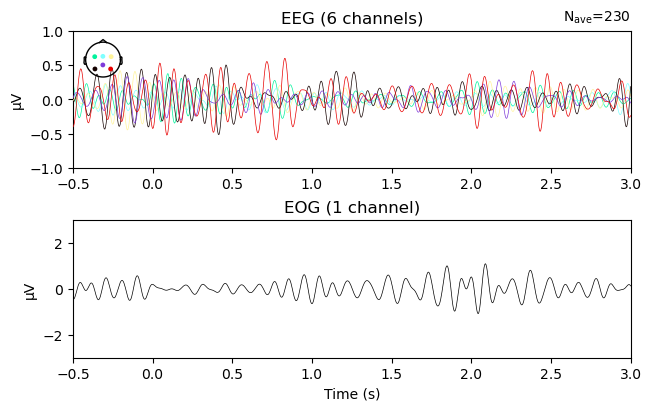

In [19]:
# Show the evoked potential computed on the corrected data
fig = epochs_clean_plain.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

#### Time Domain Plot

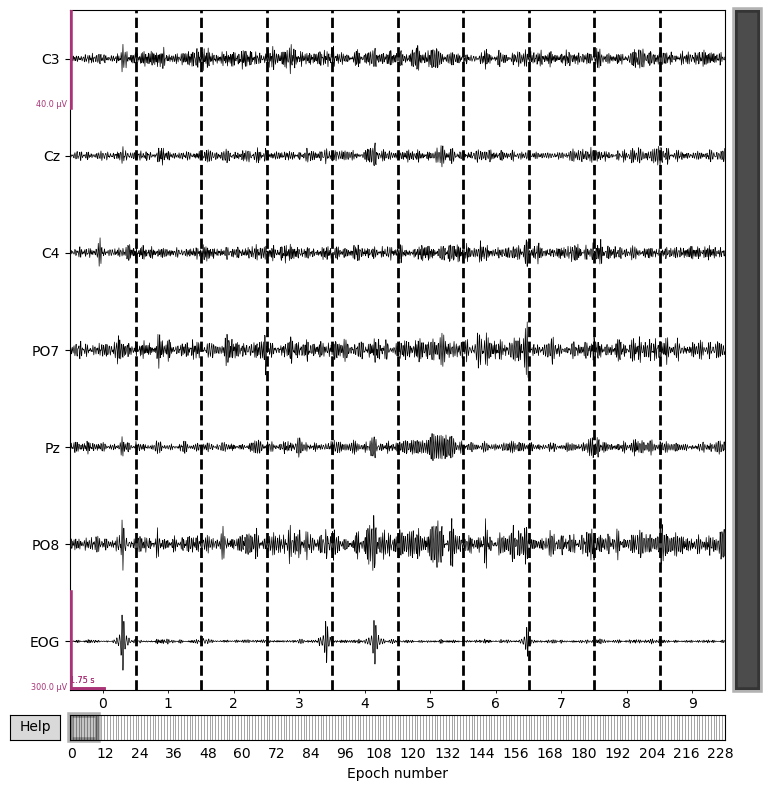

In [20]:
epochs_clean_plain.plot(picks='all', n_epochs=10);

### 2.3 Left vs. Right Classification

#### 2.3.1 SVM

Train set shape: (120, 7)
Test set shape : (30, 7)


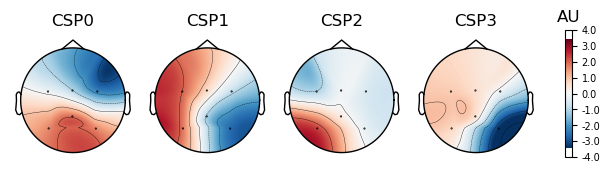

Accuracy: 0.8666666666666667
              precision    recall  f1-score   support

       right       0.82      0.93      0.87        15
        left       0.92      0.80      0.86        15

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.87      0.87      0.87        30



In [21]:
# Get EEG data and events
X = epochs_clean_plain[['right','left']].get_data(copy=False)
Y = epochs_clean_plain[['right','left']].events[:, -1]

csp_list = []
svm_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['right', 'left'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 2.3.2 Logistic Regression

Train set shape: (120, 7)
Test set shape : (30, 7)


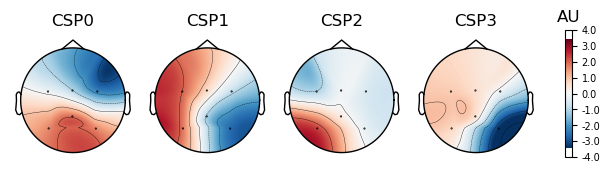

Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

  none-right       0.81      0.87      0.84        15
       right       0.86      0.80      0.83        15

    accuracy                           0.83        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.83      0.83      0.83        30



In [22]:
csp_list = []
lr_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
lr = lr_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

### 2.4 Left vs. Non-left Classification

#### 2.4.1 SVM

c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\Li

Train set shape: (184, 7)
Test set shape : (46, 7)


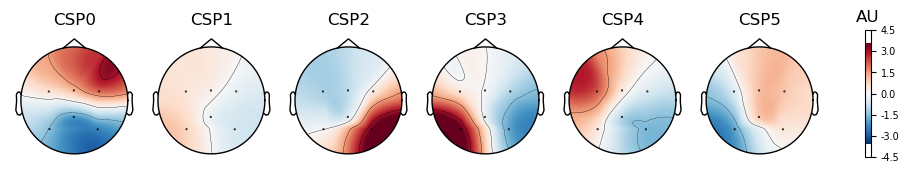

Accuracy: 0.782608695652174
              precision    recall  f1-score   support

   none-left       0.78      0.94      0.85        31
        left       0.78      0.47      0.58        15

    accuracy                           0.78        46
   macro avg       0.78      0.70      0.72        46
weighted avg       0.78      0.78      0.77        46



In [23]:
epochs_clean_plain_l = epochs_clean_plain.copy()
epochs_clean_plain_l.events = mne.merge_events(epochs_clean_plain_l.events, [0, 1], 0, replace_events=True)
epochs_clean_plain_l.event_id = {'none-left': 0, 'left': 2}

# Get EEG data and events
X = epochs_clean_plain_l.get_data(copy=False)
Y = epochs_clean_plain_l.events[:, -1]

csp_list = []
svm_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-left', 'left'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 2.4.2 Logistic Regression

Train set shape: (184, 7)
Test set shape : (46, 7)


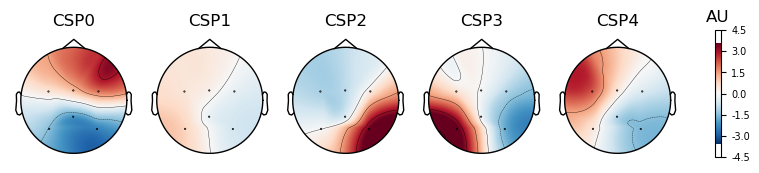

Accuracy: 0.782608695652174
              precision    recall  f1-score   support

  none-right       0.82      0.87      0.84        31
       right       0.69      0.60      0.64        15

    accuracy                           0.78        46
   macro avg       0.76      0.74      0.74        46
weighted avg       0.78      0.78      0.78        46



In [24]:
csp_list = []
lr_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
lr = lr_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

### 2.5 Right vs. Non-Right Classification

#### 2.5.1 SVM

Train set shape: (184, 7)
Test set shape : (46, 7)


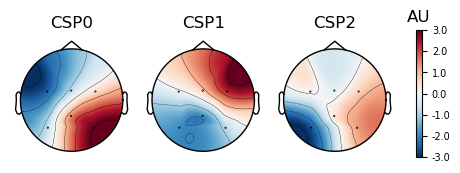

Accuracy: 0.7391304347826086
              precision    recall  f1-score   support

  none-right       0.77      0.87      0.82        31
       right       0.64      0.47      0.54        15

    accuracy                           0.74        46
   macro avg       0.70      0.67      0.68        46
weighted avg       0.73      0.74      0.73        46



In [25]:
epochs_clean_plain_r = epochs_clean_plain.copy()
epochs_clean_plain_r.events = mne.merge_events(epochs_clean_plain_r.events, [0, 2], 0, replace_events=True)
epochs_clean_plain_r.event_id = {'none-right': 0, 'right': 1}

# Get EEG data and events
X = epochs_clean_plain_r.get_data(copy=False)
Y = epochs_clean_plain_r.events[:, -1]

csp_list = []
svm_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 2.5.2 Logistic Regression

Train set shape: (184, 7)
Test set shape : (46, 7)


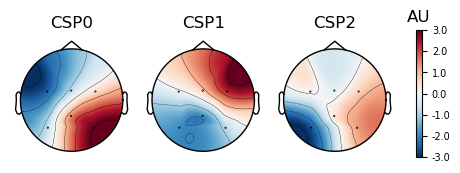

Accuracy: 0.7391304347826086
              precision    recall  f1-score   support

  none-right       0.77      0.87      0.82        31
       right       0.64      0.47      0.54        15

    accuracy                           0.74        46
   macro avg       0.70      0.67      0.68        46
weighted avg       0.73      0.74      0.73        46



In [26]:
csp_list = []
lr_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
lr = lr_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])